# Spline implementation of JAK2-STAT5 signaling pathway
In this notebook a practical example of the usage of AMICI spline functionalities is shown.
The model under consideration is the JAK2-STAT5 signaling pathway ([Swameye et al., 2003](https://doi.org/10.1073/pnas.0237333100)),
in which the dynamics of the system depend on a measured input function (the quantity `pEpoR` in the model).

Following the approach of ([Schelker et al., 2012](https://doi.org/10.1093/bioinformatics/bts393)), a continuous approximation of this input function is estimated together with the other parameters.
As in the original paper, we will use a spline with logarithmic parameterization in order to enforce the positivity constraint.

The model of the signaling pathway will be implemented in SBML using AMICI's spline annotations, experimental data integrated using the PEtab format and parameter estimation will be carried out using the [pyPESTO](https://pypesto.readthedocs.io/) library.

In [ ]:
%pip install pypesto

In [ ]:
%pip install fides

In [3]:
import os
import math
import logging
import contextlib
import multiprocessing
import copy

import numpy as np
import sympy as sp
import pandas as pd
from matplotlib import pyplot as plt

import libsbml
import amici
import petab
import pypesto
import pypesto.petab

In [4]:
# Number of multi-starts for MAP estimation
n_starts = 150
# n_starts = 0 # when loading results

In [ ]:
# Set default pypesto engine/optimizer
pypesto_optimizer = pypesto.optimize.FidesOptimizer(verbose=logging.WARNING)
pypesto_engine = pypesto.engine.MultiProcessEngine()

In [6]:
# If running as a Github action, just do the minimal amount of work required to check whether the code is working
if os.getenv('GITHUB_ACTIONS') is not None:
    n_starts = 2
    pypesto_optimizer = pypesto.optimize.FidesOptimizer(verbose=logging.WARNING, options=dict(maxiter=10))
    pypesto_engine = pypesto.engine.SingleCoreEngine()

In [7]:
# A dictionary to store different approaches for a final comparison
all_results = {}

## Spline approximation with few nodes, using finite differences for the derivatives
As a first attempt, we fix a small amount of nodes, create new parameters for the values of the splines at the nodes and let AMICI compute the derivative at the nodes by using finite differences.

### Creating the PEtab model

In [8]:
# Problem name
name = "Swameye_PNAS2003_5nodes_FD"

First, we create a spline to represent the input function `pEpoR`, parametrized by its values at the nodes.
Since the value of the input function reaches its steady state by the end of the experiment, we extrapolate constantly after that (useful if we need to simulate the model after the last spline node).

In [9]:
# Create spline for pEpoR
nodes = [0, 5, 10, 20, 60]
values_at_nodes = [sp.Symbol(f"pEpoR_t{str(t).replace('.', '_dot_')}") for t in nodes] # new parameter symbols for spline values
spline = amici.splines.CubicHermiteSpline(
    sbml_id='pEpoR', # matches name of species in SBML model
    evaluate_at=amici.sbml_utils.amici_time_symbol, # the spline is evaluated at the current time
    nodes=nodes,
    values_at_nodes=values_at_nodes, # values at the nodes (in linear scale)
    extrapolate=(None, "constant"), # because steady state is reached
    bc="auto", # automatically determined from extrapolate (bc at right end will be 'zero_derivative')
    logarithmic_parametrization=True,
)

We can then add the spline to a skeleton SBML model based on the d2d implementation by (Schelker et al., 2012).
The skeleton SBML model defines a species `pEpoR` which interacts with the other species,
but has no reactions or rate rules of its own.
The code below creates an assignment rule for `pEpoR` using the spline formula, completing the model.
The parameters `pEpoR_t*` are automatically added to the SBML model too (using nominal values of `0.1` and declaring them to be constant).

In [10]:
# Add spline formula to SBML model
sbml_doc = libsbml.SBMLReader().readSBML(os.path.join('Swameye_PNAS2003', 'swameye2003_model.xml'))
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model, auto_add=True, y_nominal=0.1, y_constant=True)

A skeleton PEtab problem is provided, containing parameter bounds, observable definitions and experimental data.
Of particular relevance is the noise model used for the measurements of `pEpoR`, normal additive noise with standard deviation equal to `0.0274 + 0.1 * pEpoR`;
this is the same choice used in (Schelker et al., 2012), where it was estimated from experimental replicates.

However, the parameters associated to the spline are to be added too.
The code below defines parameter bounds for them according to the PEtab format and then creates a full PEtab problem integrating them together with the edited SBML file.
The condition, measurement and observable PEtab tables do not require additional modification and can be used as they are.

In [11]:
# Extra parameters associated to the spline
spline_parameters_df = pd.DataFrame(
    dict(parameterScale='log', lowerBound=0.001, upperBound=10, nominalValue=0.1, estimate=1),
    index=pd.Series(list(map(str, values_at_nodes)), name="parameterId"),
)

In [12]:
# Create PEtab problem
petab_problem = petab.Problem(
    sbml_model,
    condition_df=petab.conditions.get_condition_df(os.path.join('Swameye_PNAS2003', 'swameye2003_conditions.tsv')),
    measurement_df=petab.measurements.get_measurement_df(os.path.join('Swameye_PNAS2003', 'swameye2003_measurements.tsv')),
    parameter_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_parameters.tsv'), spline_parameters_df],
        petab.parameters.get_parameter_df
    ),
    observable_df=petab.observables.get_observable_df(os.path.join('Swameye_PNAS2003', 'swameye2003_observables.tsv')),
)

The resulting PEtab problem can be checked for errors and exported to disk if needed.

In [13]:
# Check whether PEtab model is valid
assert not petab.lint_problem(petab_problem)

In [14]:
# Save PEtab problem to disk
# import shutil
# shutil.rmtree(name, ignore_errors=True)
# os.mkdir(name)
# petab_problem.to_files_generic(prefix_path=name)

### Creating the pyPESTO problem
We can now create a pyPESTO problem directly from the PEtab problem.
Due to technical limitations in AMICI, currently the PEtab problem has to be "flattened" before it can be simulated from, but such operation is merely syntactical and thus does not change the essence of the model.

In [15]:
# Problem must be "flattened" to be used with AMICI
petab.core.flatten_timepoint_specific_output_overrides(petab_problem)

In [16]:
# Check whether simulation from the PEtab problem works
# import amici.petab_simulate
# simulator = amici.petab_simulate.PetabSimulator(petab_problem)
# simulator.simulate(noise=False)

In [17]:
# Import PEtab problem into pyPESTO
pypesto_problem = pypesto.petab.PetabImporter(petab_problem, model_name=name).create_problem()

### Maximum Likelihood estimation
Using pyPESTO we can optimize for the parameter vector that maximizes the probability of observing the experimental data (maximum likelihood estimation).

A multistart method with local gradient-based optimization is used and the results of each multistart can be visualized in a waterfall plot. 

In [18]:
# Load existing results if available
if os.path.exists(f'{name}.h5'):
    pypesto_result = pypesto.store.read_result(f'{name}.h5', problem=pypesto_problem)
else:
    pypesto_result = None
# Overwrite
# pypesto_result = None

In [ ]:
# Parallel multistart optimization with pyPESTO and FIDES
if n_starts > 0:
    if pypesto_result is None:
        new_ids = [str(i) for i in range(n_starts)]
    else:
        last_id = max(int(i) for i in pypesto_result.optimize_result.id)
        new_ids = [str(i) for i in range(last_id+1, last_id+n_starts+1)]
    pypesto_result = pypesto.optimize.minimize(
        pypesto_problem,
        n_starts=n_starts,
        ids=new_ids,
        optimizer=pypesto_optimizer,
        engine=pypesto_engine,
        result=pypesto_result,
    )
    pypesto_result.optimize_result.sort()
    if pypesto_result.optimize_result.x[0] is None:
        raise Exception("All multistarts failed (n_starts is probably too small)! If this error occurred during CI, just run the workflow again.")

In [20]:
# Save results to disk
# pypesto.store.write_result(pypesto_result, f'{name}.h5', overwrite=True)

In [21]:
# Print result table
# pypesto_result.optimize_result.as_dataframe()

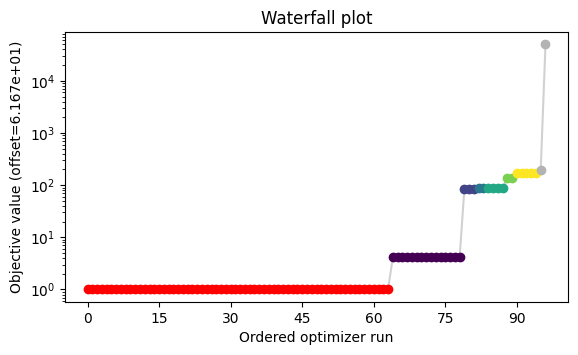

In [22]:
# Visualize the results of the multistarts
pypesto.visualize.waterfall(pypesto_result, size=[6.5, 3.5]);

Below the maximum likelihood estimates for `pEpoR` and the other observables are plotted, together with the experimental measurements.

To assess whether the noise model used in the observable is reasonable, we have also plotted 2-sigma error bands for `pEpoR`.

In [23]:
# Functions for simulating observables given a parameter vector
def _simulate(x=None, *, problem=None, result=None, N=500, **kwargs):
    if result is None:
        result = pypesto_result
    if problem is None:
        problem = pypesto_problem
    if x is None:
        x = result.optimize_result.x[0]
    if N is None:
        objective = problem.objective
    else:
        objective = problem.objective.set_custom_timepoints(timepoints_global=np.linspace(0, 60, N))
    if len(x) != len(problem.x_free_indices):
        x = x[problem.x_free_indices]
    simresult = objective(x, return_dict=True, **kwargs)
    return problem, simresult['rdatas'][0]

def simulate_pEpoR(x=None, **kwargs):
    problem, rdata = _simulate(x, **kwargs)
    assert problem.objective.amici_model.getObservableIds()[0].startswith('pEpoR')
    return rdata['t'], rdata['y'][:, 0]

def simulate_pSTAT5(x=None, **kwargs):
    problem, rdata = _simulate(x, **kwargs)
    assert problem.objective.amici_model.getObservableIds()[1].startswith('pSTAT5')
    return rdata['t'], rdata['y'][:, 1]

def simulate_tSTAT5(x=None, **kwargs):
    problem, rdata = _simulate(x, **kwargs)
    assert problem.objective.amici_model.getObservableIds()[-1].startswith('tSTAT5')
    return rdata['t'], rdata['y'][:, -1]

# Experimental data
df_measurements = petab.measurements.get_measurement_df(os.path.join('Swameye_PNAS2003', 'swameye2003_measurements.tsv'))
df_pEpoR = df_measurements[df_measurements['observableId'].str.startswith('pEpoR')]
df_pSTAT5 = df_measurements[df_measurements['observableId'].str.startswith('pSTAT5')]
df_tSTAT5 = df_measurements[df_measurements['observableId'].str.startswith('tSTAT5')]

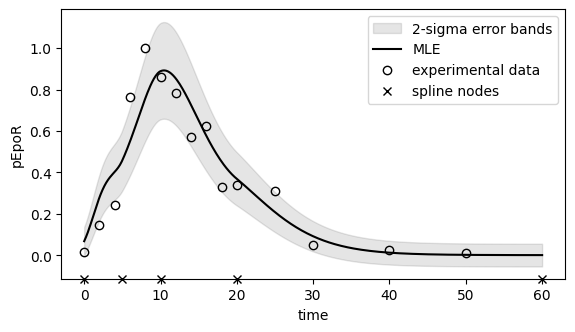

In [24]:
# Plot ML fit for pEpoR
fig, ax = plt.subplots(figsize=(6.5, 3.5))
t, pEpoR = simulate_pEpoR()
sigma_pEpoR = 0.0274 + 0.1 * pEpoR
ax.fill_between(t, pEpoR - 2*sigma_pEpoR, pEpoR + 2*sigma_pEpoR, color='black', alpha=0.10, interpolate=True, label='2-sigma error bands')
ax.plot(t, pEpoR, color='black', label='MLE')
ax.plot(df_pEpoR['time'], df_pEpoR['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pEpoR")
ax.legend();

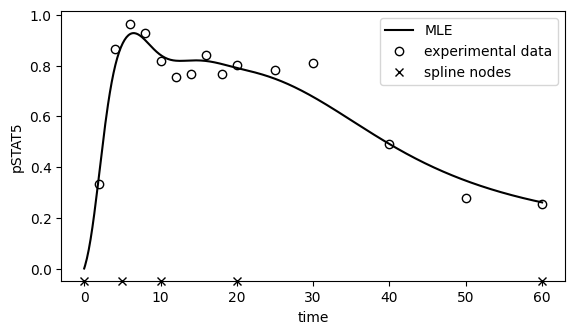

In [25]:
# Plot ML fit for pSTAT5
fig, ax = plt.subplots(figsize=(6.5, 3.5))
t, pSTAT5 = simulate_pSTAT5()
ax.plot(t, pSTAT5, color='black', label='MLE')
ax.plot(df_pSTAT5['time'], df_pSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pSTAT5")
ax.legend();

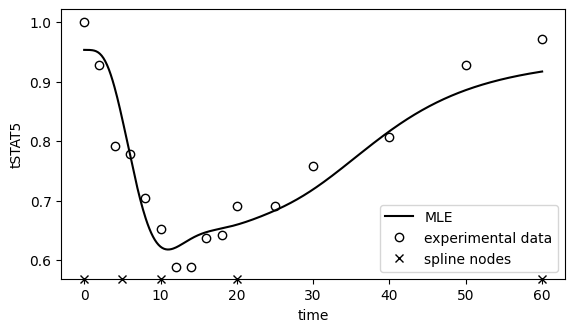

In [26]:
# Plot ML fit for tSTAT5
fig, ax = plt.subplots(figsize=(6.5, 3.5))
t, tSTAT5 = simulate_tSTAT5()
ax.plot(t, tSTAT5, color='black', label='MLE')
ax.plot(df_tSTAT5['time'], df_tSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("tSTAT5")
ax.legend();

In [27]:
# Store results for later
all_results['5 nodes, FD'] = (pypesto_problem, pypesto_result)

## Spline approximation with many nodes, using finite differences for the derivatives
Five nodes is arguably not enough to represent all plausible input choices. Increasing the number of nodes would give the spline more freedom and it can be done with minimal changes to the example above. However, more degrees of freedom mean more chance of overfitting. Thus, following (Schelker et al., 2012), we will add a regularization term consisting in the squared L2 norm of the spline's curvature, which promotes smoother and less oscillating functions. The value for the regularization strength $\lambda$ is chosen by comparing the sum of squared normalized residuals with its expected value, which can be computing by assuming it is roughly $\chi^2$-distributed.

### Creating the PEtab model

In [28]:
# Problem name
name = "Swameye_PNAS2003_15nodes_FD"

In [29]:
# Create spline for pEpoR
nodes = [0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20, 25, 30, 35, 40, 50, 60]
values_at_nodes = [sp.Symbol(f"pEpoR_t{str(t).replace('.', '_dot_')}") for t in nodes]
spline = amici.splines.CubicHermiteSpline(
    sbml_id='pEpoR',
    evaluate_at=amici.sbml_utils.amici_time_symbol,
    nodes=nodes,
    values_at_nodes=values_at_nodes,
    extrapolate=(None, "constant"),
    bc="auto",
    logarithmic_parametrization=True,
)

The regularization term can be easily computed by symbolic manipulation of the spline expression using AMICI and SymPy. Since it is very commonly used, we already provide a function for it in AMICI. Note: we regularize the curvature of the spline, which for positivity-enforcing spline is the logarithm of the function.

In order add the regularization term to the PEtab likelihood, a dummy observable has to be created.

In [30]:
# Compute L2 norm of the curvature of pEpoR
regularization = spline.squared_L2_norm_of_curvature()

In [31]:
# Add a parameter for regularization strength
reg_parameters_df = pd.DataFrame(
    dict(parameterScale='log10', lowerBound=1e-6, upperBound=1e6, nominalValue=1.0, estimate=0),
    index=pd.Series(['regularization_strength'], name="parameterId"),
)
# Encode regularization term as an additional observable
reg_observables_df = pd.DataFrame(
    dict(observableFormula=str(regularization).replace('**', '^'), observableTransformation='lin', noiseFormula='1/regularization_strength', noiseDistribution='normal'),
    index=pd.Series(['regularization'], name="observableId"),
)
# and correspoding measurement
reg_measurements_df = pd.DataFrame(
    dict(observableId='regularization', simulationConditionId='condition1', measurement=0, time=0, observableTransformation='lin'),
    index=pd.Series([0]),
)

In [32]:
# Add spline formula to SBML model
sbml_doc = libsbml.SBMLReader().readSBML(os.path.join('Swameye_PNAS2003', 'swameye2003_model.xml'))
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model, auto_add=True, y_nominal=0.1, y_constant=True)

In [33]:
# Extra parameters associated to the spline
spline_parameters_df = pd.DataFrame(
    dict(parameterScale='log', lowerBound=0.001, upperBound=10, nominalValue=0.1, estimate=1),
    index=pd.Series(list(map(str, values_at_nodes)), name="parameterId"),
)

In [34]:
# Create PEtab problem
petab_problem = petab.Problem(
    sbml_model,
    condition_df=petab.conditions.get_condition_df(os.path.join('Swameye_PNAS2003', 'swameye2003_conditions.tsv')),
    measurement_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_measurements.tsv'), reg_measurements_df],
        petab.measurements.get_measurement_df
    ).reset_index(drop=True),
    parameter_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_parameters.tsv'), spline_parameters_df, reg_parameters_df],
        petab.parameters.get_parameter_df
    ),
    observable_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_observables.tsv'), reg_observables_df],
        petab.observables.get_observable_df
    ),
)

In [35]:
# Check whether PEtab model is valid
assert not petab.lint_problem(petab_problem)

In [36]:
# Save PEtab problem to disk
# import shutil
# shutil.rmtree(name, ignore_errors=True)
# os.mkdir(name)
# petab_problem.to_files_generic(prefix_path=name)

### Creating the pyPESTO problem

In [37]:
# Problem must be "flattened" to be used with AMICI
petab.core.flatten_timepoint_specific_output_overrides(petab_problem)

In [38]:
# Check whether simulation from the PEtab problem works
# import amici.petab_simulate
# simulator = amici.petab_simulate.PetabSimulator(petab_problem)
# simulator.simulate(noise=False)

In [39]:
# Import PEtab problem into pyPESTO
pypesto_problem = pypesto.petab.PetabImporter(petab_problem, model_name=name).create_problem()

### Maximum Likelihood estimation
We will optimize the problem for different values of the regularization strength $\lambda$, then compute the sum of squared normalized residuals for each of the resulting parameter vectors. The one for which such a value is nearest to its expected value of $15$ (the number of observations from the input function) will be chosen as the final estimate.

In [ ]:
# Try different regularization strengths
regstrengths = np.asarray([1.0, 5.0, 10.0, 15.0, 20.0, 25.0])
if os.getenv('GITHUB_ACTIONS') is not None:
    regstrengths = np.asarray([15.0])
regproblems = {}
regresults = {}

for regstrength in regstrengths:
    # Fix parameter in pypesto problem
    name = f"Swameye_PNAS2003_15nodes_FD_reg{regstrength}"
    pypesto_problem.fix_parameters(
        pypesto_problem.x_names.index('regularization_strength'),
        np.log10(regstrength) # parameter is specified as log10 scale in PEtab
    )
    regproblem = copy.deepcopy(pypesto_problem)
    
    # Load existing results if available
    if os.path.exists(f'{name}.h5'):
        regresult = pypesto.store.read_result(f'{name}.h5', problem=regproblem)
    else:
        regresult = None
    # Overwrite
    # regresult = None
    
    # Parallel multistart optimization with pyPESTO and FIDES
    if n_starts > 0:
        if regresult is None:
            new_ids = [str(i) for i in range(n_starts)]
        else:
            last_id = max(int(i) for i in regresult.optimize_result.id)
            new_ids = [str(i) for i in range(last_id+1, last_id+n_starts+1)]
        regresult = pypesto.optimize.minimize(
            regproblem,
            n_starts=n_starts,
            ids=new_ids,
            optimizer=pypesto_optimizer,
            engine=pypesto_engine,
            result=regresult,
        )
        regresult.optimize_result.sort()
        if regresult.optimize_result.x[0] is None:
            raise Exception("All multistarts failed (n_starts is probably too small)! If this error occurred during CI, just run the workflow again.")
    
    # Save results to disk
    # pypesto.store.write_result(regresult, f'{name}.h5', overwrite=True)
    
    # Store result
    regproblems[regstrength] = regproblem
    regresults[regstrength] = regresult

In [41]:
# Compute sum of squared normalized residuals
print(f"Target value is {len(df_pEpoR['time'])}")
regstrengths = sorted(regproblems.keys())
stats = []
for regstrength in regstrengths:
    t, pEpoR = simulate_pEpoR(N=None, problem=regproblems[regstrength], result=regresults[regstrength])
    assert np.array_equal(df_pEpoR['time'], t[:-1])
    pEpoR = pEpoR[:-1]
    sigma_pEpoR = 0.0274 + 0.1 * pEpoR
    stat = np.sum(((pEpoR - df_pEpoR['measurement']) / sigma_pEpoR)**2)
    print(f"Regularization strength: {regstrength}. Statistic is {stat}")
    stats.append(stat)
# Select best regularization strength
chosen_regstrength = regstrengths[np.abs(np.asarray(stats) - len(df_pEpoR['time'])).argmin()]

Target value is 15
Regularization strength: 1.0. Statistic is 7.030807705490437
Regularization strength: 5.0. Statistic is 9.152568862468632
Regularization strength: 10.0. Statistic is 11.985037227657417
Regularization strength: 15.0. Statistic is 14.570576812942898
Regularization strength: 20.0. Statistic is 16.842274892776782
Regularization strength: 25.0. Statistic is 18.850258296441257


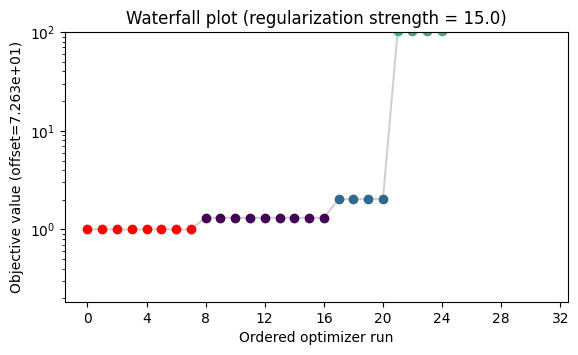

In [42]:
# Visualize the results of the multistarts for a chosen regularization strength
ax = pypesto.visualize.waterfall(regresults[chosen_regstrength], size=[6.5, 3.5])
ax.set_title(f"Waterfall plot (regularization strength = {chosen_regstrength})")
ax.set_ylim(ax.get_ylim()[0], 100);

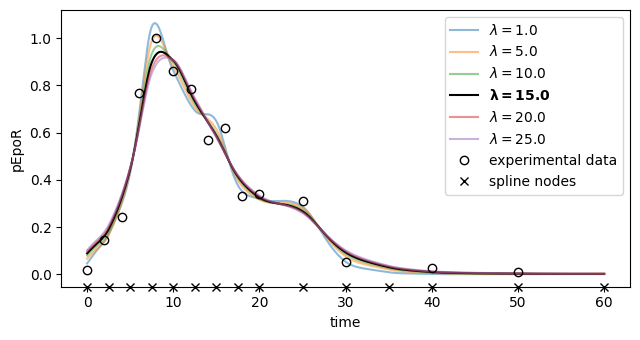

In [43]:
# Plot ML fit for pEpoR (all regularization strengths)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for regstrength in sorted(regproblems.keys()):
    t, pEpoR = simulate_pEpoR(problem=regproblems[regstrength], result=regresults[regstrength])
    if regstrength == chosen_regstrength:
        kwargs = dict(color='black', label=f'$\\mathbf{{\\lambda = {regstrength}}}$', zorder=2)
    else:
        kwargs = dict(label=f'$\\lambda = {regstrength}$', alpha=0.5)
    ax.plot(t, pEpoR, **kwargs)
ax.plot(df_pEpoR['time'], df_pEpoR['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pEpoR")
ax.legend()
ax.figure.tight_layout()
#ax.figure.savefig('fit_15nodes_lambdas.pdf')

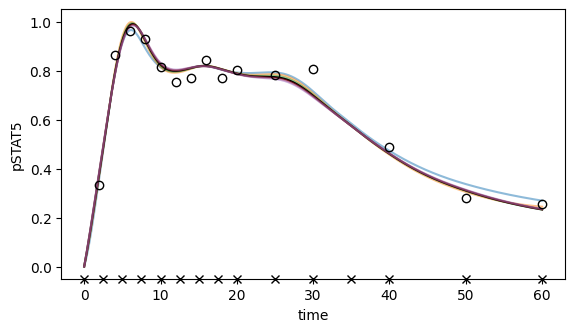

In [44]:
# Plot ML fit for pSTAT5 (all regularization strengths)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for regstrength in sorted(regproblems.keys()):
    t, pSTAT5 = simulate_pSTAT5(problem=regproblems[regstrength], result=regresults[regstrength])
    if regstrength == chosen_regstrength:
        kwargs = dict(color='black', label=f'$\\mathbf{{\\lambda = {regstrength}}}$', zorder=2)
    else:
        kwargs = dict(label=f'$\\lambda = {regstrength}$', alpha=0.5)
    ax.plot(t, pSTAT5, **kwargs)
ax.plot(df_pSTAT5['time'], df_pSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pSTAT5");
#ax.legend();

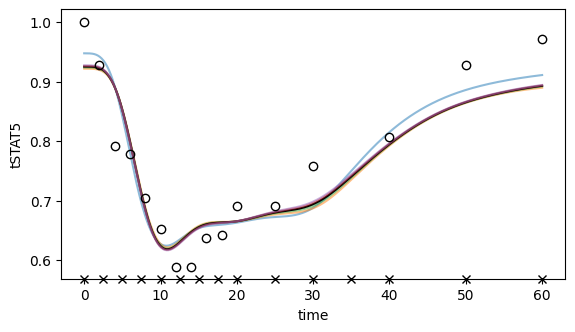

In [45]:
# Plot ML fit for tSTAT5 (all regularization strengths)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for regstrength in sorted(regproblems.keys()):
    t, tSTAT5 = simulate_tSTAT5(problem=regproblems[regstrength], result=regresults[regstrength])
    if regstrength == chosen_regstrength:
        kwargs = dict(color='black', label=f'$\\mathbf{{\\lambda = {regstrength}}}$', zorder=2)
    else:
        kwargs = dict(label=f'$\\lambda = {regstrength}$', alpha=0.5)
    ax.plot(t, tSTAT5, **kwargs)
ax.plot(df_tSTAT5['time'], df_tSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("tSTAT5");
#ax.legend();

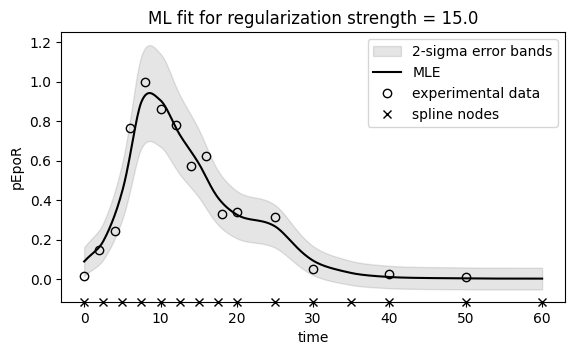

In [46]:
# Plot ML fit for pEpoR (single regularization strength with noise model)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
t, pEpoR = simulate_pEpoR(problem=regproblems[chosen_regstrength], result=regresults[chosen_regstrength])
sigma_pEpoR = 0.0274 + 0.1 * pEpoR
ax.fill_between(t, pEpoR - 2*sigma_pEpoR, pEpoR + 2*sigma_pEpoR, color='black', alpha=0.10, interpolate=True, label='2-sigma error bands')
ax.plot(t, pEpoR, color='black', label='MLE')
ax.plot(df_pEpoR['time'], df_pEpoR['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pEpoR")
ax.set_title(f"ML fit for regularization strength = {chosen_regstrength}")
ax.legend();

In [47]:
# Store results for later
all_results['15 nodes, FD'] = (regproblems[chosen_regstrength], regresults[chosen_regstrength])

## Spline approximation with few nodes, optimizing derivatives explicitly
An alternative way to achieve higher expressivity, while not increasing the number of nodes, is to optimize the derivatives of the spline at the nodes instead of computing them by finite differencing. The risk of overfitting is still present, so we will include regularization as in the above example.

### Creating the PEtab model

In [48]:
# Problem name
name = "Swameye_PNAS2003_5nodes"

We now need to create additional parameters for the spline derivatives too.

In [49]:
# Create spline for pEpoR
nodes = [0, 5, 10, 20, 60]
values_at_nodes = [sp.Symbol(f"pEpoR_t{str(t).replace('.', '_dot_')}") for t in nodes]
derivatives_at_nodes = [sp.Symbol(f"derivative_pEpoR_t{str(t).replace('.', '_dot_')}") for t in nodes[:-1]]
spline = amici.splines.CubicHermiteSpline(
    sbml_id='pEpoR',
    evaluate_at=amici.sbml_utils.amici_time_symbol,
    nodes=nodes,
    values_at_nodes=values_at_nodes,
    derivatives_at_nodes=derivatives_at_nodes + [0], # last value is zero because steady state is reached
    extrapolate=(None, "constant"),
    bc="auto",
    logarithmic_parametrization=True,
)

In [50]:
# Compute L2 norm of the curvature of pEpoR
regularization = spline.squared_L2_norm_of_curvature()

In [51]:
# Add a parameter for regularization strength
reg_parameters_df = pd.DataFrame(
    dict(parameterScale='log10', lowerBound=1e-6, upperBound=1e6, nominalValue=1.0, estimate=0),
    index=pd.Series(['regularization_strength'], name="parameterId"),
)
# Encode regularization term as an additional observable
reg_observables_df = pd.DataFrame(
    dict(observableFormula=str(regularization).replace('**', '^'), observableTransformation='lin', noiseFormula='1/regularization_strength', noiseDistribution='normal'),
    index=pd.Series(['regularization'], name="observableId"),
)
# and correspoding measurement
reg_measurements_df = pd.DataFrame(
    dict(observableId='regularization', simulationConditionId='condition1', measurement=0, time=0, observableTransformation='lin'),
    index=pd.Series([0]),
)

In [52]:
# Add spline formula to SBML model
sbml_doc = libsbml.SBMLReader().readSBML(os.path.join('Swameye_PNAS2003', 'swameye2003_model.xml'))
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model, auto_add=True, y_nominal=0.1, y_constant=True)

In [53]:
# Derivative parameters must be added separately
for p in derivatives_at_nodes:
    amici.sbml_utils.add_parameter(sbml_model, p, value=0.0, constant=True)

In [54]:
# Extra parameters associated to the spline
spline_parameters_df1 = pd.DataFrame(
    dict(parameterScale='log', lowerBound=0.001, upperBound=10, nominalValue=0.1, estimate=1),
    index=pd.Series(list(map(str, values_at_nodes)), name="parameterId"),
)
spline_parameters_df2 = pd.DataFrame(
    dict(parameterScale='lin', lowerBound=-0.666, upperBound=0.666, nominalValue=0.0, estimate=1),
    index=pd.Series(list(map(str, derivatives_at_nodes)), name="parameterId"),
)

In [55]:
# Create PEtab problem
petab_problem = petab.Problem(
    sbml_model,
    condition_df=petab.conditions.get_condition_df(os.path.join('Swameye_PNAS2003', 'swameye2003_conditions.tsv')),
    measurement_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_measurements.tsv'), reg_measurements_df],
        petab.measurements.get_measurement_df
    ).reset_index(drop=True),
    parameter_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_parameters.tsv'), spline_parameters_df1, spline_parameters_df2, reg_parameters_df],
        petab.parameters.get_parameter_df
    ),
    observable_df=petab.core.concat_tables(
        [os.path.join('Swameye_PNAS2003', 'swameye2003_observables.tsv'), reg_observables_df],
        petab.observables.get_observable_df
    ),
)

In [56]:
# Check whether PEtab model is valid
assert not petab.lint_problem(petab_problem)

In [57]:
# Save PEtab problem to disk
# import shutil
# shutil.rmtree(name, ignore_errors=True)
# os.mkdir(name)
# petab_problem.to_files_generic(prefix_path=name)

### Creating the pyPESTO problem

In [58]:
# Problem must be "flattened" to be used with AMICI
petab.core.flatten_timepoint_specific_output_overrides(petab_problem)

In [59]:
# Check whether simulation from the PEtab problem works
# import amici.petab_simulate
# simulator = amici.petab_simulate.PetabSimulator(petab_problem)
# simulator.simulate(noise=False)

In [60]:
# Import PEtab problem into pyPESTO
pypesto_problem = pypesto.petab.PetabImporter(petab_problem, model_name=name).create_problem()

### Maximum Likelihood estimation

In [ ]:
# Try different regularization strengths
regstrengths = np.asarray([0.1, 1.0, 25.0, 50.0, 100.0])
if os.getenv('GITHUB_ACTIONS') is not None:
    regstrengths = np.asarray([50.0])
regproblems = {}
regresults = {}

for regstrength in regstrengths:
    # Fix parameter in pypesto problem
    name = f"Swameye_PNAS2003_5nodes_reg{regstrength}"
    pypesto_problem.fix_parameters(
        pypesto_problem.x_names.index('regularization_strength'),
        np.log10(regstrength) # parameter is specified as log10 scale in PEtab
    )
    regproblem = copy.deepcopy(pypesto_problem)
    
    # Load existing results if available
    if os.path.exists(f'{name}.h5'):
        regresult = pypesto.store.read_result(f'{name}.h5', problem=regproblem)
    else:
        regresult = None
    # Overwrite
    # regresult = None
    
    # Parallel multistart optimization with pyPESTO and FIDES
    if n_starts > 0:
        if regresult is None:
            new_ids = [str(i) for i in range(n_starts)]
        else:
            last_id = max(int(i) for i in regresult.optimize_result.id)
            new_ids = [str(i) for i in range(last_id+1, last_id+n_starts+1)]
        regresult = pypesto.optimize.minimize(
            regproblem,
            n_starts=n_starts,
            ids=new_ids,
            optimizer=pypesto_optimizer,
            engine=pypesto_engine,
            result=regresult,
        )
        regresult.optimize_result.sort()
        if regresult.optimize_result.x[0] is None:
            raise Exception("All multistarts failed (n_starts is probably too small)! If this error occurred during CI, just run the workflow again.")
    
    # Save results to disk
    # pypesto.store.write_result(regresult, f'{name}.h5', overwrite=True)
    
    # Store result
    regproblems[regstrength] = regproblem
    regresults[regstrength] = regresult

In [62]:
# Compute sum of squared normalized residuals
print(f"Target value is {len(df_pEpoR['time'])}")
regstrengths = sorted(regproblems.keys())
stats = []
for regstrength in regstrengths:
    t, pEpoR = simulate_pEpoR(N=None, problem=regproblems[regstrength], result=regresults[regstrength])
    assert np.array_equal(df_pEpoR['time'], t[:-1])
    pEpoR = pEpoR[:-1]
    sigma_pEpoR = 0.0274 + 0.1 * pEpoR
    stat = np.sum(((pEpoR - df_pEpoR['measurement']) / sigma_pEpoR)**2)
    print(f"Regularization strength: {regstrength}. Statistic is {stat}")
    stats.append(stat)
# Select best regularization strength
chosen_regstrength = regstrengths[np.abs(np.asarray(stats) - len(df_pEpoR['time'])).argmin()]

Target value is 15
Regularization strength: 0.1. Statistic is 9.582855446307638
Regularization strength: 1.0. Statistic is 9.825408363453471
Regularization strength: 25.0. Statistic is 13.576458635090578
Regularization strength: 50.0. Statistic is 15.627354151527097
Regularization strength: 100.0. Statistic is 20.512939643037786


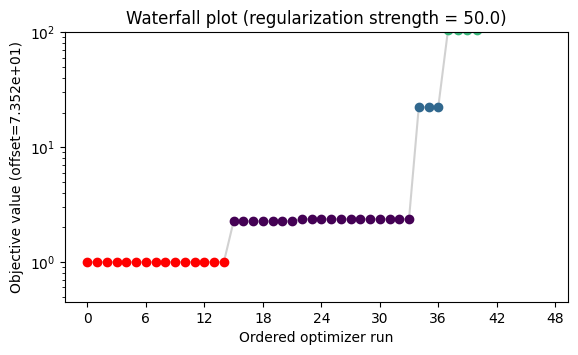

In [63]:
# Visualize the results of the multistarts for a chosen regularization strength
ax = pypesto.visualize.waterfall(regresults[chosen_regstrength], size=[6.5, 3.5])
ax.set_title(f"Waterfall plot (regularization strength = {chosen_regstrength})")
ax.set_ylim(ax.get_ylim()[0], 100);

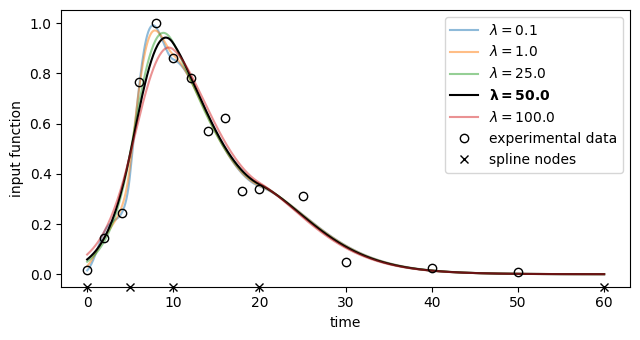

In [64]:
# Plot ML fit for pEpoR (all regularization strengths)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for regstrength in sorted(regproblems.keys()):
    t, pEpoR = simulate_pEpoR(problem=regproblems[regstrength], result=regresults[regstrength])
    if regstrength == chosen_regstrength:
        kwargs = dict(color='black', label=f'$\\mathbf{{\\lambda = {regstrength}}}$', zorder=2)
    else:
        kwargs = dict(label=f'$\\lambda = {regstrength}$', alpha=0.5)
    ax.plot(t, pEpoR, **kwargs)
ax.plot(df_pEpoR['time'], df_pEpoR['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
#ax.set_ylabel("pEpoR")
ax.set_ylabel("input function")
ax.legend()
ax.figure.tight_layout()
#ax.figure.savefig('fit_5nodes_lambdas.pdf')

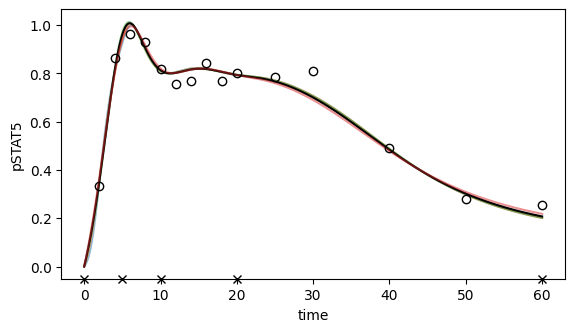

In [65]:
# Plot ML fit for pSTAT5 (all regularization strengths)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for regstrength in sorted(regproblems.keys()):
    t, pSTAT5 = simulate_pSTAT5(problem=regproblems[regstrength], result=regresults[regstrength])
    if regstrength == chosen_regstrength:
        kwargs = dict(color='black', label=f'$\\mathbf{{\\lambda = {regstrength}}}$', zorder=2)
    else:
        kwargs = dict(label=f'$\\lambda = {regstrength}$', alpha=0.5)
    ax.plot(t, pSTAT5, **kwargs)
ax.plot(df_pSTAT5['time'], df_pSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pSTAT5");
# ax.legend();

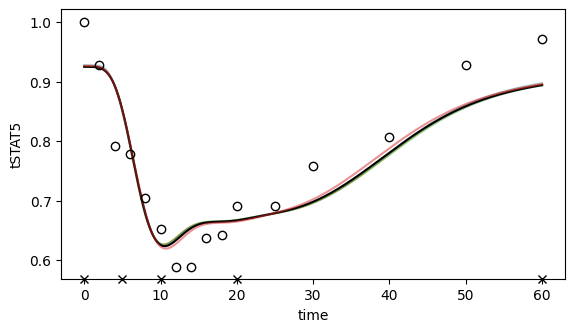

In [66]:
# Plot ML fit for tSTAT5 (all regularization strengths)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for regstrength in sorted(regproblems.keys()):
    t, tSTAT5 = simulate_tSTAT5(problem=regproblems[regstrength], result=regresults[regstrength])
    if regstrength == chosen_regstrength:
        kwargs = dict(color='black', label=f'$\\mathbf{{\\lambda = {regstrength}}}$', zorder=2)
    else:
        kwargs = dict(label=f'$\\lambda = {regstrength}$', alpha=0.5)
    ax.plot(t, tSTAT5, **kwargs)
ax.plot(df_tSTAT5['time'], df_tSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("tSTAT5");
# ax.legend();

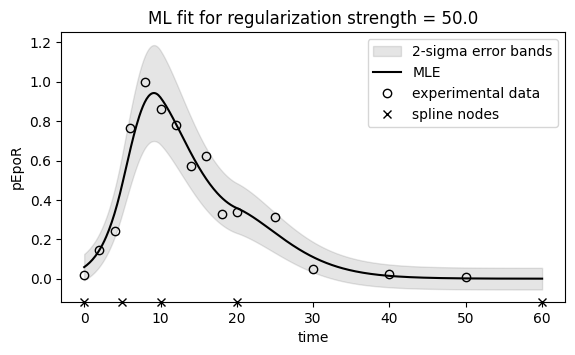

In [67]:
# Plot ML fit for pEpoR (single regularization strength with noise model)
fig, ax = plt.subplots(figsize=(6.5, 3.5))
t, pEpoR = simulate_pEpoR(problem=regproblems[chosen_regstrength], result=regresults[chosen_regstrength])
sigma_pEpoR = 0.0274 + 0.1 * pEpoR
ax.fill_between(t, pEpoR - 2*sigma_pEpoR, pEpoR + 2*sigma_pEpoR, color='black', alpha=0.10, interpolate=True, label='2-sigma error bands')
ax.plot(t, pEpoR, color='black', label='MLE')
ax.plot(df_pEpoR['time'], df_pEpoR['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ylim1 = ax.get_ylim()[0]
ax.plot(nodes, len(nodes)*[ylim1], 'x', color='black', label='spline nodes', zorder=10, clip_on=False)
ax.set_ylim(ylim1, ax.get_ylim()[1])
ax.set_xlabel("time")
ax.set_ylabel("pEpoR")
ax.set_title(f"ML fit for regularization strength = {chosen_regstrength}")
ax.legend();

In [68]:
# Store results for later
all_results['5 nodes'] = (regproblems[chosen_regstrength], regresults[chosen_regstrength])

## Comparing the three approaches

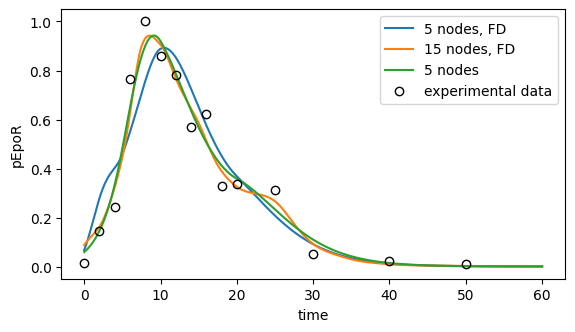

In [69]:
# Plot ML fit for pEpoR
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for (label, (problem, result)) in all_results.items():
    t, pEpoR = simulate_pEpoR(problem=problem, result=result)
    ax.plot(t, pEpoR, label=label)
ax.plot(df_pEpoR['time'], df_pEpoR['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ax.set_xlabel("time")
ax.set_ylabel("pEpoR")
ax.legend();

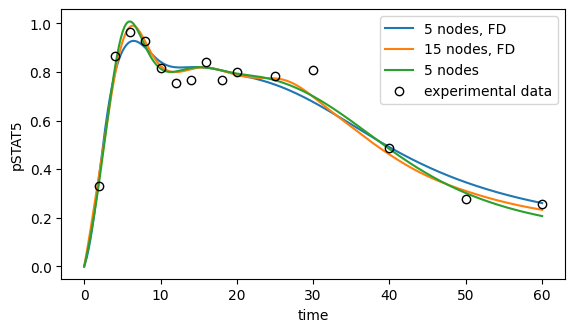

In [70]:
# Plot ML fit for pSTAT5
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for (label, (problem, result)) in all_results.items():
    t, pSTAT5 = simulate_pSTAT5(problem=problem, result=result)
    ax.plot(t, pSTAT5, label=label)
ax.plot(df_pSTAT5['time'], df_pSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ax.set_xlabel("time")
ax.set_ylabel("pSTAT5")
ax.legend();

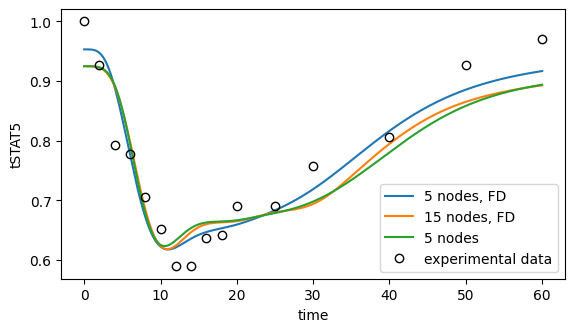

In [71]:
# Plot ML fit for tSTAT5
fig, ax = plt.subplots(figsize=(6.5, 3.5))
for (label, (problem, result)) in all_results.items():
    t, tSTAT5 = simulate_tSTAT5(problem=problem, result=result)
    ax.plot(t, tSTAT5, label=label)
ax.plot(df_tSTAT5['time'], df_tSTAT5['measurement'], 'o', color='black', markerfacecolor='none', label='experimental data')
ax.set_xlabel("time")
ax.set_ylabel("tSTAT5")
ax.legend();

In [72]:
# Compare parameter values
for (label, (problem, result)) in all_results.items():
    print(f"\n### {label}")
    x = result.optimize_result.x[0]
    if len(x) == len(problem.x_free_indices):
        names = problem.x_names[problem.x_free_indices]
    else:
        names = problem.x_names
    for (name, value) in zip(names, x):
        print(f"{name} = {value}")


### 5 nodes, FD
k1 = -0.012346575380759206
k2 = -1.1197589279067723
k3 = 5.999997815270413
k4 = 0.2257597245272905
scale_tSTAT5 = -0.020792393248152102
scale_pSTAT5 = 0.14225557598779293
sigma_pEpoR_abs = -1.562249437179612
sigma_pEpoR_rel = -1.0
pEpoR_t0 = -2.6870850145649072
pEpoR_t5 = -0.7797617204168674
pEpoR_t10 = -0.11820672467656843
pEpoR_t20 = -0.9974233456398647
pEpoR_t60 = -6.90775527898212

### 15 nodes, FD
k1 = 0.16040219319460045
k2 = -1.0080813376919948
k3 = -0.18004184783054922
k4 = 0.3139691989174595
scale_tSTAT5 = -0.03376103675489285
scale_pSTAT5 = 0.10905523587944772
sigma_pEpoR_abs = -1.562249437179612
sigma_pEpoR_rel = -1.0
pEpoR_t0 = -2.4217110013271506
pEpoR_t2_dot_5 = -1.6534914183463365
pEpoR_t5_dot_0 = -0.8056642018961185
pEpoR_t7_dot_5 = -0.10814042780791792
pEpoR_t10_dot_0 = -0.09934320617862673
pEpoR_t12_dot_5 = -0.31084550708254577
pEpoR_t15_dot_0 = -0.5337897526450585
pEpoR_t17_dot_5 = -0.8826846636998659
pEpoR_t20 = -1.120965417684128
pEpoR_t25 = -1.321

## Bibliography
Schelker, M. et al. (2012). “Comprehensive estimation of input signals and dynamics in biochemical reaction networks”. In: Bioinformatics 28.18, pp. i529–i534. doi: [10.1093/bioinformatics/bts393](https://doi.org/10.1093/bioinformatics/bts393).

Swameye, I. et al. (2003). “Identification of nucleocytoplasmic cycling as a remote sensor in cellular signaling by databased modeling”. In: Proceedings of the National Academy of Sciences 100.3, pp. 1028–1033. doi: [10.1073/pnas.0237333100](https://doi.org/10.1073/pnas.0237333100).